# Prostate Cancer Classification Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Functions

In [8]:
def check_for_null_dupes(df):
  print(f"The Amount of Nulls: {df.isna().sum()}")
  print(f"The Amount of Dupes: {df.duplicated().sum()}")
  

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, startangle=140, autopct="%1.1f%%")
  plt.title("Target Class Breakdown")
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Target Class")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

# EDA Analysis

In [3]:
df = pd.read_csv("/Users/maukanmir/Downloads/prostate.csv")
df

,lcavol,lweight,age,lbph,lcp,gleason,pgg45,lpsa,Target
0,-0.579818,2.769459,50,-1.386294,-1.386294,6,0,-0.430783,0
1,-0.994252,3.319626,58,-1.386294,-1.386294,6,0,-0.162519,0
2,-0.510826,2.691243,74,-1.386294,-1.386294,7,20,-0.162519,0
3,-1.203973,3.282789,58,-1.386294,-1.386294,6,0,-0.162519,0
4,0.751416,3.432373,62,-1.386294,-1.386294,6,0,0.371564,0
...,...,...,...,...,...,...,...,...,...
92,2.830268,3.876396,68,-1.386294,1.321756,7,60,4.385147,1
93,3.821004,3.896909,44,-1.386294,2.169054,7,40,4.684443,1
94,2.907447,3.396185,52,-1.386294,2.463853,7,10,5.143124,1
95,2.882564,3.773910,68,1.558145,1.558145,7,80,5.477509,1


# Check For Nulls And Dupes

In [4]:
check_for_null_dupes(df)

The Amount of Nulls: lcavol     0
lweight    0
age        0
lbph       0
lcp        0
gleason    0
pgg45      0
lpsa       0
Target     0
dtype: int64
The Amount of Dupes: 0


# Check Class Imbalance

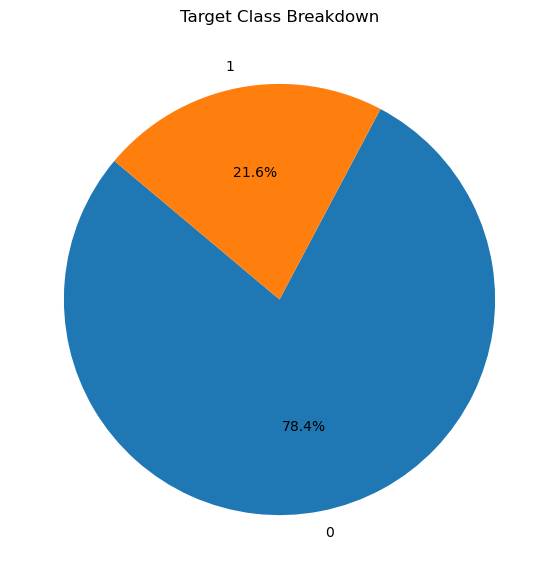

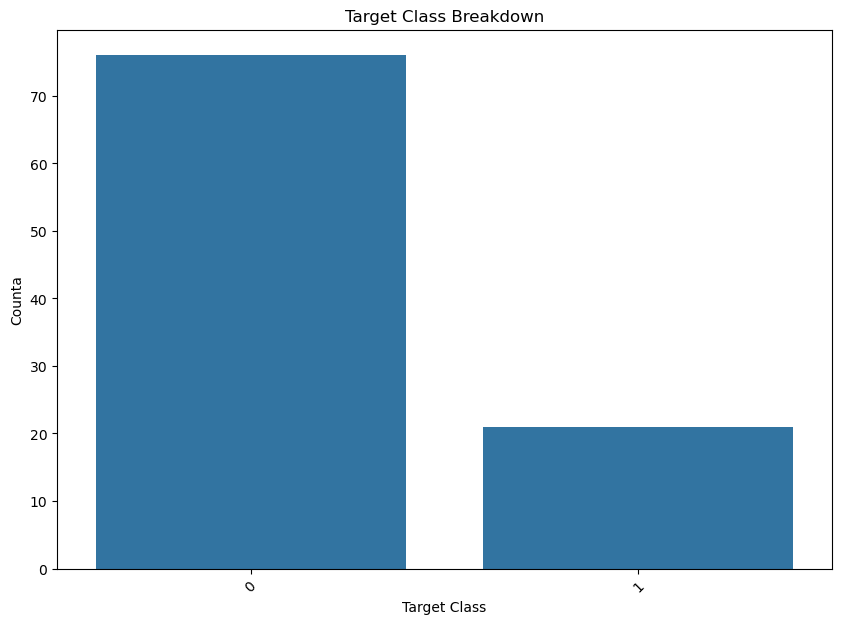

In [7]:
check_class_imbalance(df["Target"])

In [9]:
df.dtypes

lcavol     float64
lweight    float64
age          int64
lbph       float64
lcp        float64
gleason      int64
pgg45        int64
lpsa       float64
Target       int64
dtype: object

In [10]:
df.describe()

,lcavol,lweight,age,lbph,lcp,gleason,pgg45,lpsa,Target
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,1.350010,3.628943,63.865979,0.100356,-0.179366,6.752577,24.381443,2.478387,0.216495
std,1.178625,0.428411,7.445117,1.450807,1.398250,0.722134,28.204035,1.154329,0.413995
min,-1.347074,2.374906,41.000000,-1.386294,-1.386294,6.000000,0.000000,-0.430783,0.000000
25%,0.512824,3.375880,60.000000,-1.386294,-1.386294,6.000000,0.000000,1.731656,0.000000
50%,1.446919,3.623007,65.000000,0.300105,-0.798508,7.000000,15.000000,2.591516,0.000000
75%,2.127041,3.876396,68.000000,1.558145,1.178655,7.000000,40.000000,3.056357,0.000000
max,3.821004,4.780383,79.000000,2.326302,2.904165,9.000000,100.000000,5.582932,1.000000


# Visuals

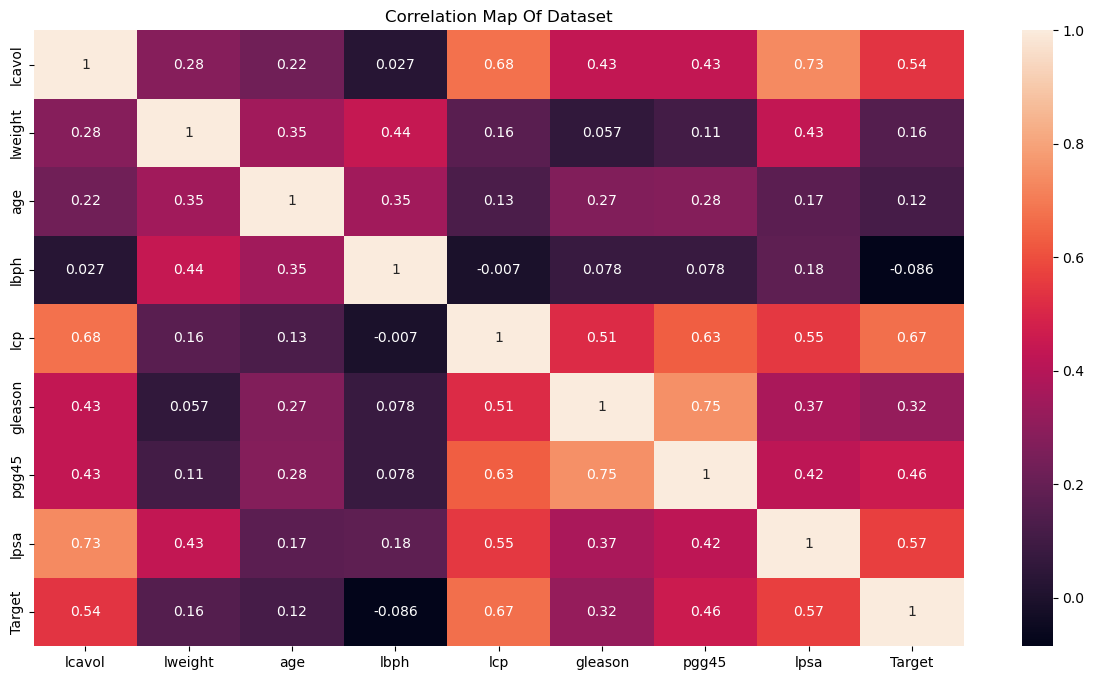

In [12]:
relations = df.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(data=relations, annot=True)
plt.title("Correlation Map Of Dataset")
plt.show()

# A lot of these features are highly correlated, we may be able to reduce our features through PCA analysis given that some maybe not needed.